<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/03-27-2020.csv"
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [48]:
us_pop = 329968629  #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US: {res.positive/us_pop*100:2f}%")

positive     99447
negative    527220
pending      60094
total       686761
dtype: int64
Current Infection Rate 14.480583%
Percentage of US: 0.030138%


In [49]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative
37,NY,44635,101118
34,NJ,8825,16547
5,CA,3879,17380
24,MI,3657,6550
21,MA,3240,26131
52,WA,3207,43173
16,IL,3060,18516
10,FL,2765,28186
20,LA,2746,18613
41,PA,2218,21016


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA.positive.sum().reset_index().copy()
dfCAPos = gbCA.positive.sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [51]:
dfUSAPos[-7:]

,date,positive,PCT
17,20200321,23197,0.233260
18,20200322,31879,0.320563
19,20200323,42152,0.423864
20,20200324,51954,0.522429
21,20200325,63928,0.642835
22,20200326,80735,0.811839
23,20200327,99447,1.000000


In [52]:
dfCAPos[-7:]

,date,positive,PCT
17,20200321,1279,0.329724
18,20200322,1536,0.395978
19,20200323,1733,0.446765
20,20200324,2102,0.541892
21,20200325,2355,0.607115
22,20200326,3006,0.774942
23,20200327,3879,1.000000


In [53]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalized,death,total,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,
20200323,42152,237321,14571,3325.0,471,294044,279473,73.0,771.0,43858.0,10273.0,54131.0
20200324,51954,292758,14433,4468.0,675,359145,344712,204.0,1143.0,55437.0,9802.0,65239.0
20200325,63928,357604,51235,6136.0,900,472767,421532,225.0,1668.0,64846.0,11974.0,76820.0
20200326,80735,438603,60251,10131.0,1163,579589,519338,264.0,3996.0,80999.0,16807.0,97806.0
20200327,99447,527220,60094,12035.0,1530,686761,626667,367.0,1970.0,88617.0,18712.0,107329.0


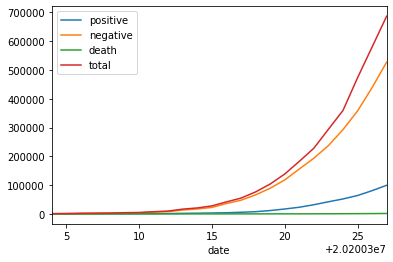

In [54]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [55]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
20200314,1678,41
20200315,1678,41
20200316,1678,41
20200317,3503,58
20200318,3536,58
20200319,7087,100
20200320,10442,150
20200321,15219,201
20200322,15219,201


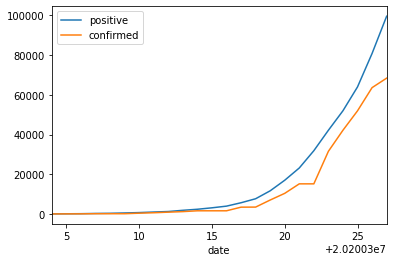

In [56]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [57]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalized,death,total,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,
20200321,1279,11249,0,0.0,24,12528,12528,4.0,0.0,825.0,216.0,1041.0
20200322,1536,11304,0,0.0,27,12840,12840,3.0,0.0,55.0,257.0,312.0
20200323,1733,12567,12100,0.0,27,26400,14300,0.0,0.0,1263.0,197.0,1460.0
20200324,2102,13452,12100,0.0,40,27654,15554,13.0,0.0,885.0,369.0,1254.0
20200325,2355,15921,48600,0.0,53,66876,18276,13.0,0.0,2469.0,253.0,2722.0
20200326,3006,17380,57400,0.0,65,77786,20386,12.0,0.0,1459.0,651.0,2110.0
20200327,3879,17380,57400,746.0,78,78659,21259,13.0,746.0,0.0,873.0,873.0


In [58]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    101657
dead           1581
dtype: int64

In [59]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    4657
dead           94
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [61]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                101657
Italy              86498
China              81897
Spain              65719
Germany            50871
France             33402
Iran               32332
United Kingdom     14745
Switzerland        12928
Korea, South        9332
Name: confirmed, dtype: int64

In [62]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(20)

country
US                101657
Italy              86498
China              81897
Spain              65719
Germany            50871
France             33402
Iran               32332
United Kingdom     14745
Switzerland        12928
Korea, South        9332
Netherlands         8647
Austria             7657
Belgium             7284
Turkey              5698
Canada              4682
Portugal            4268
Norway              3755
Brazil              3417
Australia           3143
Sweden              3069
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [67]:
dfState.loc['NY'].head(7)

,date,positive,current_total,pct
state,,,,
NY,20200327,44635,44635,1.000000
NY,20200326,37258,44635,0.834726
NY,20200325,30811,44635,0.690288
NY,20200324,25665,44635,0.574997
NY,20200323,20875,44635,0.467682
NY,20200322,15168,44635,0.339823
NY,20200321,10356,44635,0.232015


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

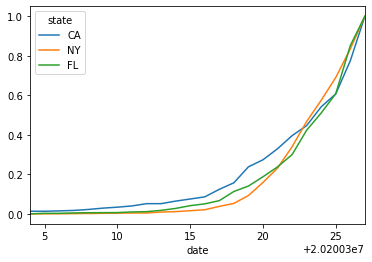

In [69]:
x = res.loc[:, ['CA','NY','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

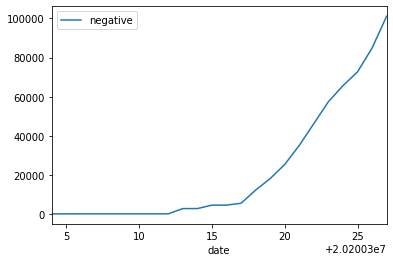

In [71]:
x = dfNYTesting.plot.line()

In [72]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['GA']))].head(10)

,state,date,positive,current_total,pct
238,GA,20200327,2001,2001,1.000000
239,GA,20200326,1525,2001,0.762119
240,GA,20200325,1247,2001,0.623188
241,GA,20200324,1026,2001,0.512744
242,GA,20200323,772,2001,0.385807
243,GA,20200322,600,2001,0.299850
244,GA,20200321,507,2001,0.253373
245,GA,20200320,420,2001,0.209895
246,GA,20200319,287,2001,0.143428
247,GA,20200318,197,2001,0.098451


In [73]:
datecutoff = int(((pd.to_datetime(str(dfDates.date.max())))-datetime.timedelta(days=2)).strftime("%Y%m%d"))
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .60)].sort_values(by='positive',ascending=False)


,state,date,positive,current_total,pct
731,NJ,20200325,4402,8825,0.498810
451,MA,20200325,1838,3240,0.567284
891,PA,20200325,1127,2218,0.508115
1014,TX,20200325,974,1731,0.562681
364,IN,20200325,477,981,0.486239
475,MD,20200325,423,774,0.546512
564,MO,20200325,356,669,0.532138
24,AL,20200325,283,587,0.482112
867,OR,20200325,209,414,0.504831
846,OK,20200325,164,322,0.509317
